<h1> Laboratory work 1:  Text classification </h1>

Authors: Alexei Trutnev, Frolova Olga

## Exploratory data analysis

<h3> Dataset descriptions </h3>

The dataset <a href="https://www.kaggle.com/datasets/jp797498e/twitter-entity-sentiment-analysis/data" target="_blank">  Twitter Sentiment Analysis </a> is used.

In this laboratory work, we explore the fundamental principles of text classification using natural language processing (NLP) techniques. Text classification is one of the core tasks in NLP and has broad applications in areas such as sentiment analysis, spam detection, and document categorization. The objective of this task is to automatically categorize textual data into predefined classes based on its content.

We will focus on sentiment analysis, a popular application of text classification, where the goal is to determine the sentiment expressed in a piece of text. Specifically, we will be working with a real-world dataset from Twitter that contains messages mentioning specific entities. Our task is to classify the sentiment of each message towards the mentioned entity as Positive, Negative, or Neutral.


In [1]:
from functools import partial
from pathlib import Path

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

from src.classification.classical_ml import (ClassicClassification,
                                             ClassicClassificationType)
from src.classification.quality import estimate_quality
from src.preprocessing import (convert_to_lowercase, load_dataset,
                               normalization_text, remove_extra_spaces,
                               remove_special_characters, remove_stop_words,
                               removing_digits, set_seed)
from src.utils import dump_dict, get_subset
from src.vectorizer import Vectorizer, VectorizerType
from src.visualization import (distribution_chart,
                               generate_sentiment_wordclouds,
                               sentiment_distribution_chart)


set_seed()

[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/alexgiving/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/alexgiving/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
train_path = Path('data/twitter_training.csv')
df = load_dataset(train_path)

## EDA

In [3]:
df.head(10)

,id,entity,sentiment,content
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...
5,2401,Borderlands,Positive,im getting into borderlands and i can murder y...
6,2402,Borderlands,Positive,So I spent a few hours making something for fu...
7,2402,Borderlands,Positive,So I spent a couple of hours doing something f...
8,2402,Borderlands,Positive,So I spent a few hours doing something for fun...
9,2402,Borderlands,Positive,So I spent a few hours making something for fu...


### Check the empty and irrelevant data

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74682 entries, 0 to 74681
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         74682 non-null  int64 
 1   entity     74682 non-null  object
 2   sentiment  74682 non-null  object
 3   content    73996 non-null  object
dtypes: int64(1), object(3)
memory usage: 2.3+ MB


Our dataset has empty `content` samples

In [5]:
df.dropna(inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 73996 entries, 0 to 74681
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         73996 non-null  int64 
 1   entity     73996 non-null  object
 2   sentiment  73996 non-null  object
 3   content    73996 non-null  object
dtypes: int64(1), object(3)
memory usage: 2.8+ MB


### Сheck duplication

In [6]:
print(f'Number of duplicates in the dataset: {df.duplicated().sum()}')
df.drop_duplicates(inplace=True)
print(f'After remove duplicates, number of duplicates in the dataset: {df.duplicated().sum()}')

Number of duplicates in the dataset: 2340
After remove duplicates, number of duplicates in the dataset: 0


### Distribution of sentiment

In [7]:
sentiment_counts = df['sentiment'].value_counts()
sentiment_counts

sentiment
Negative      21698
Positive      19713
Neutral       17708
Irrelevant    12537
Name: count, dtype: int64

/var/folders/87/3cnclgy53jd11fkzc4qp7mlc0000gn/T/ipykernel_19746/3713511204.py:1: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  distribution_chart(sentiment_counts,'sentiment').show()


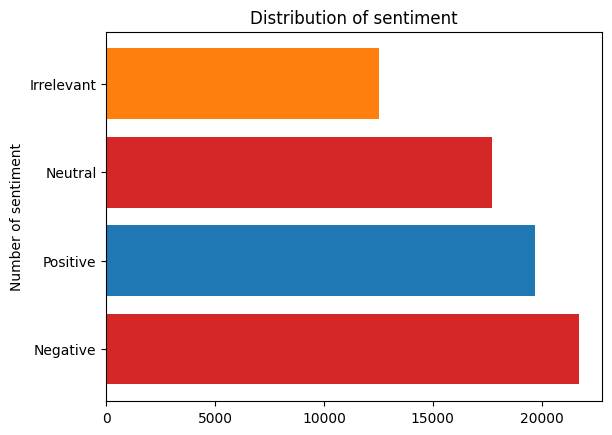

In [8]:
distribution_chart(sentiment_counts,'sentiment').show()

### Distribution of entity

/var/folders/87/3cnclgy53jd11fkzc4qp7mlc0000gn/T/ipykernel_19746/2919378985.py:2: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  distribution_chart(entity, 'entity').show()


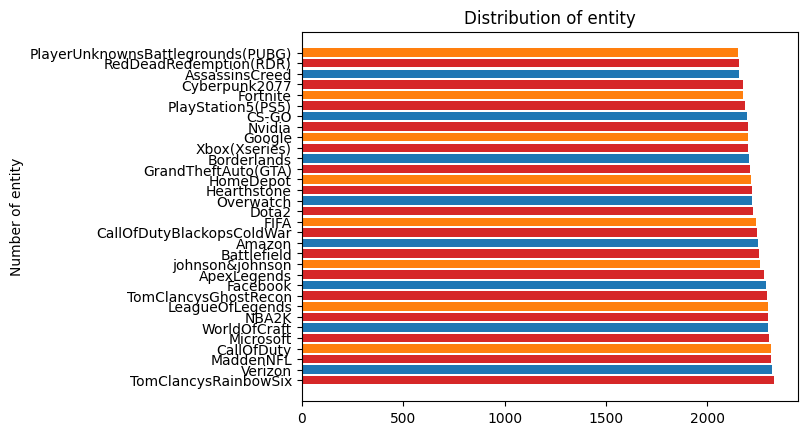

In [9]:
entity = df['entity'].value_counts()
distribution_chart(entity, 'entity').show()

### Distribution of sentiment by entity

/var/folders/87/3cnclgy53jd11fkzc4qp7mlc0000gn/T/ipykernel_19746/621010469.py:1: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  sentiment_distribution_chart(df, 'entity', 'sentiment').show()


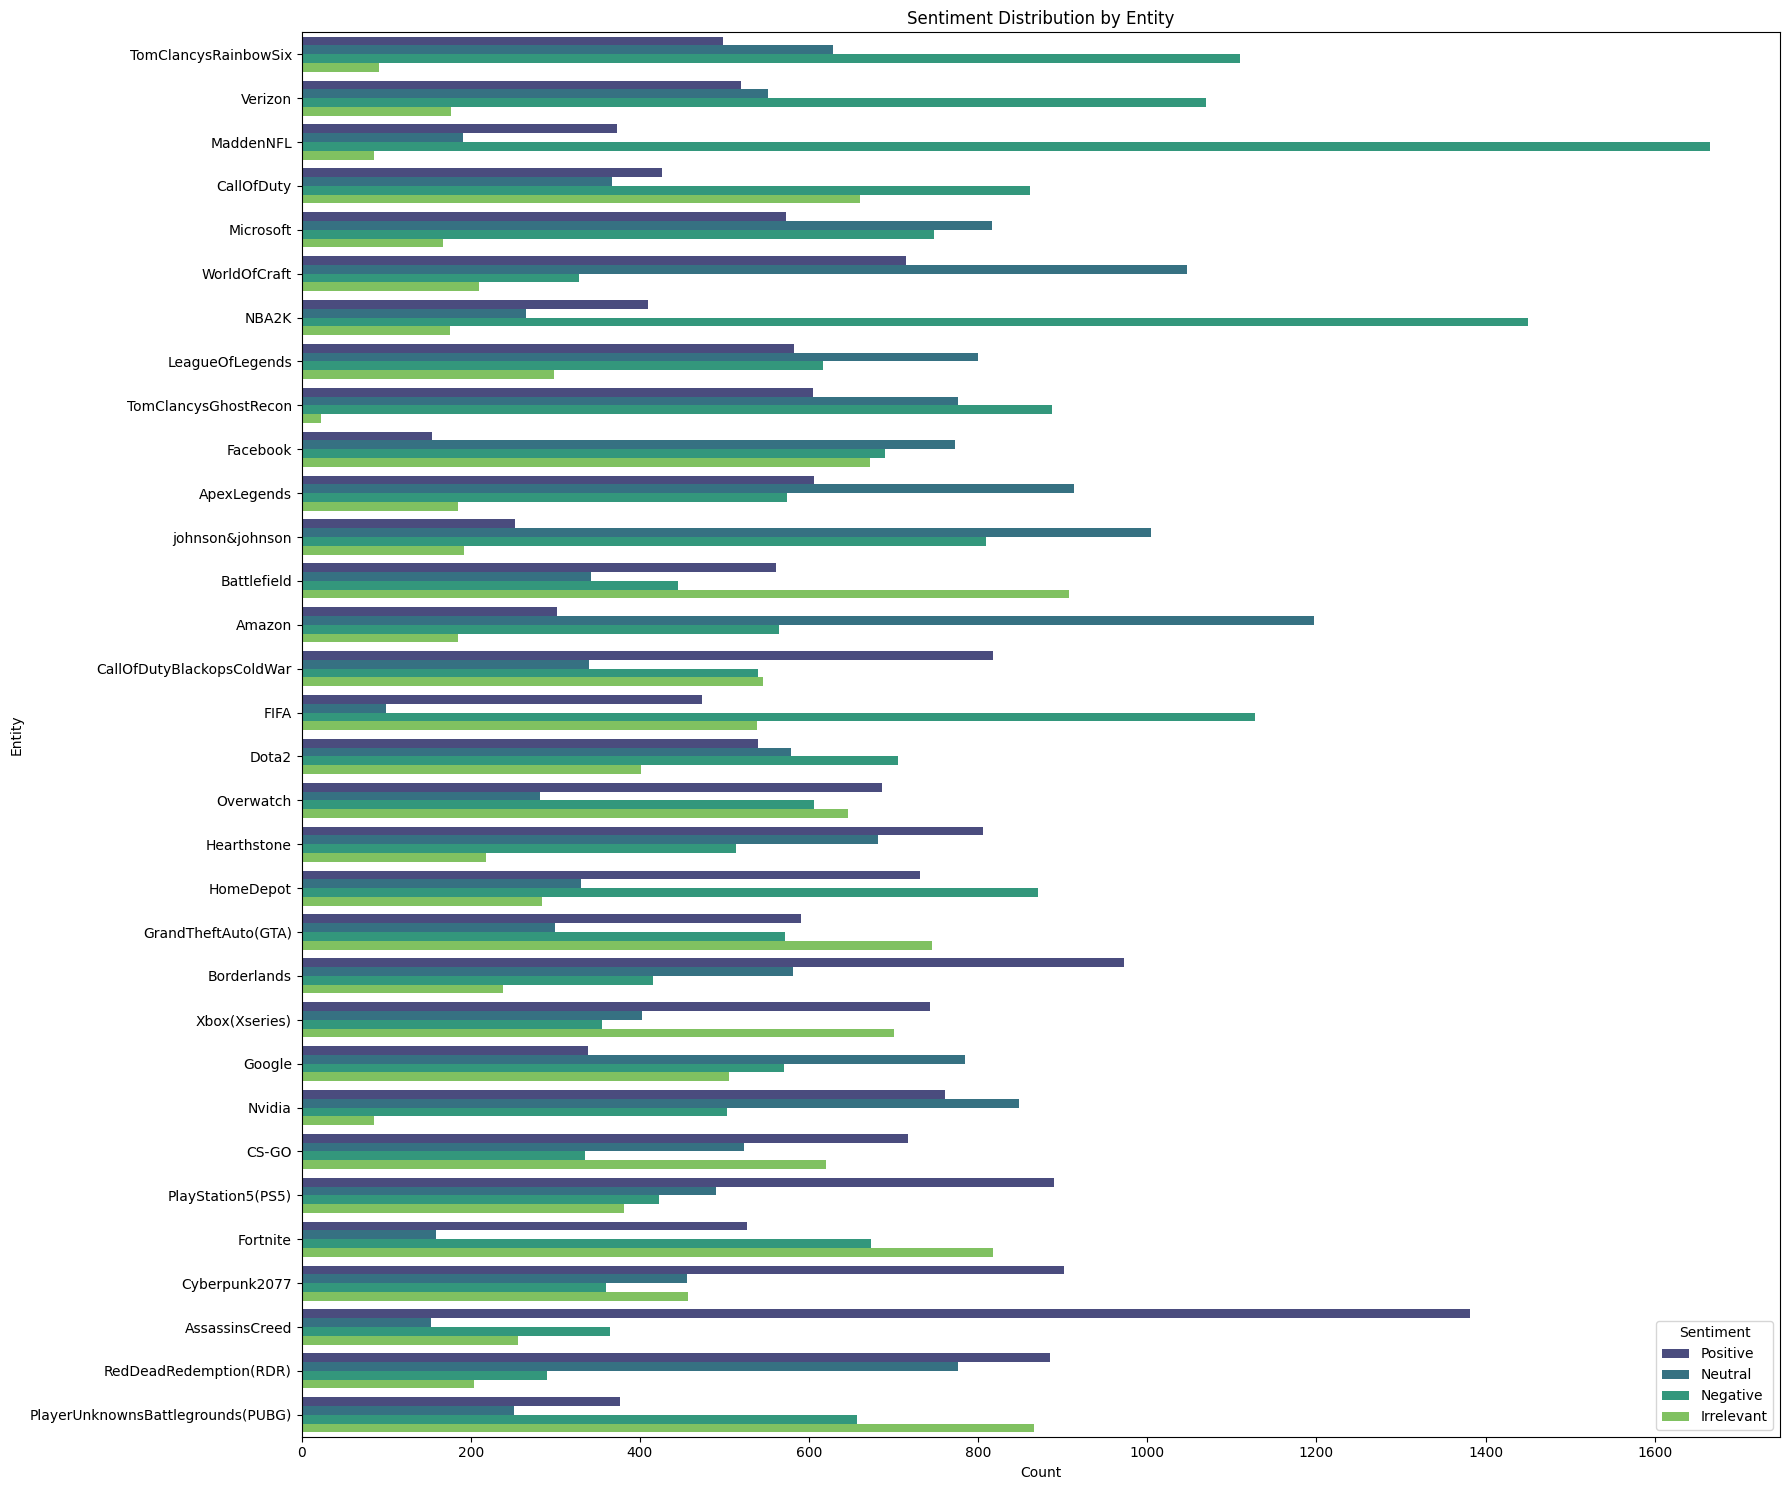

In [10]:
sentiment_distribution_chart(df, 'entity', 'sentiment').show()

### Word Cloud for each group sentiment 

/var/folders/87/3cnclgy53jd11fkzc4qp7mlc0000gn/T/ipykernel_19746/4027139701.py:4: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  sentiments=['Positive', 'Negative', 'Neutral', 'Irrelevant']).show()


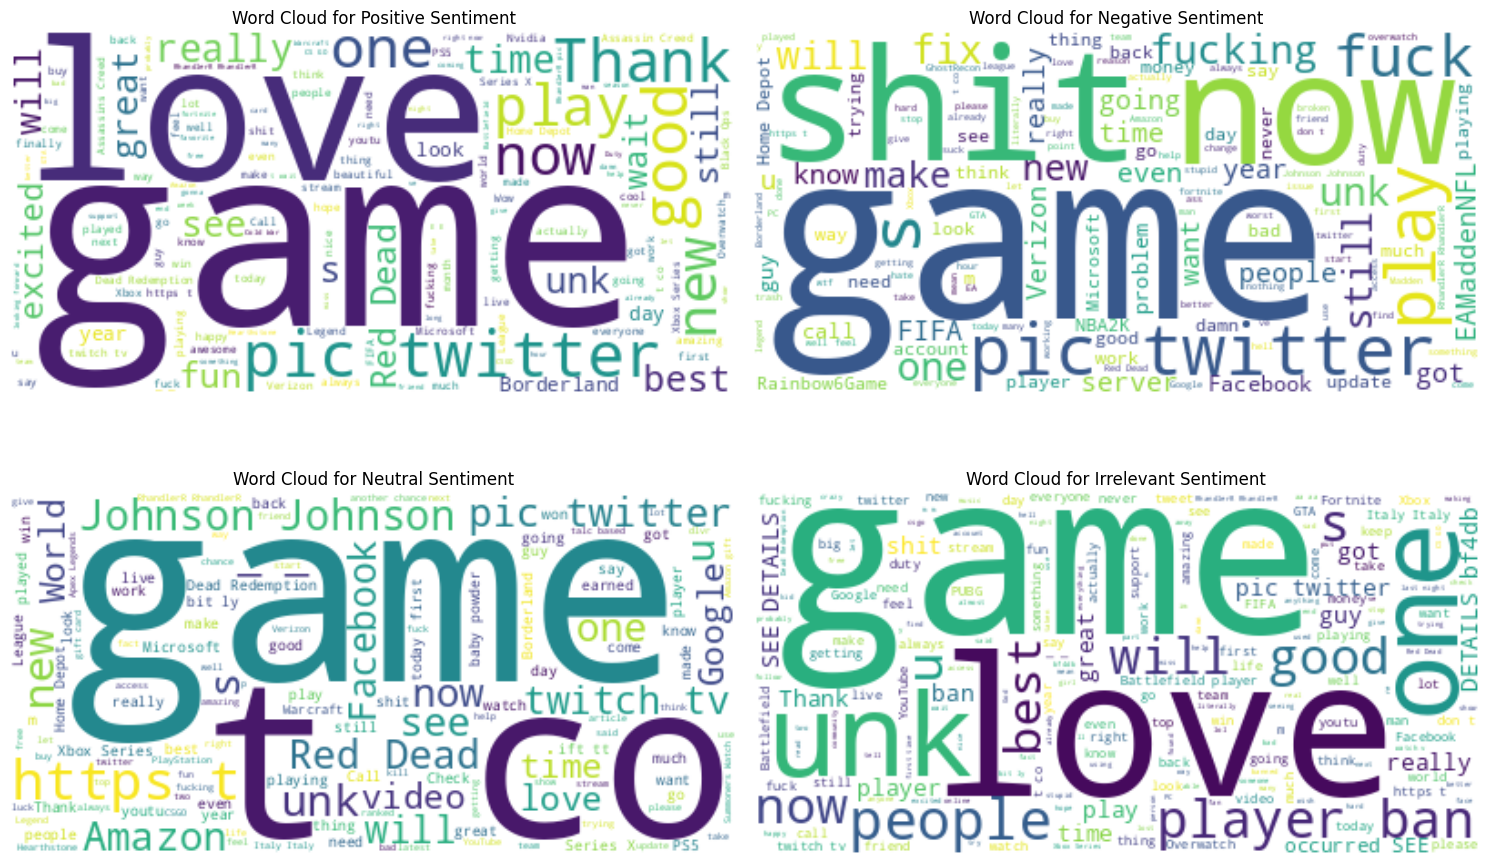

In [11]:
generate_sentiment_wordclouds(data=df,
                              sentiment_col='sentiment',
                              text_col='content',
                              sentiments=['Positive', 'Negative', 'Neutral', 'Irrelevant']).show()

### Data preprocessing

In [12]:
# remove stop words
df['content'] = df['content'].apply(remove_stop_words)
# remove special characters
df['content']= df['content'].apply(remove_special_characters)
# remove digits
df['content']= df['content'].apply(removing_digits)
# convert text to lowercase
df['content']= df['content'].apply(convert_to_lowercase)
# remove extra space
df['content']= df['content'].apply(remove_extra_spaces)

### After removing stop words here could be problems with the empty content

In [13]:
print('Num of empty content samples:', sum(df['content'] == ''))
df = df[df['content'] != '']

Num of empty content samples: 1582


### The label column should be encoded

In [14]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
df['sentiment'] = label_encoder.fit_transform(df['sentiment'])

In [15]:
df['content_lemma'] = df['content'].apply(lambda text: normalization_text('lemmatization', text))
df['content_stemming'] = df['content'].apply(lambda text: normalization_text('stemming', text))
df['content_combo'] = df['content'].apply(lambda text: normalization_text('combo', text))

## Prepare result dict

In [16]:
results = []

In [17]:
df_sub = get_subset(df, n_samples = 100, random_state = 42)

### Embeddings

In [18]:
train_test_split = partial(train_test_split, test_size=0.2, random_state=42)

# We will have 4 variants for analysis

X_train, X_test, y_train, y_test = train_test_split(df_sub['content'], df_sub['sentiment'])
X_train_lemma, X_test_lemma, y_train_lemma, y_test_lemma = train_test_split(df_sub['content_lemma'], df_sub['sentiment'])
X_train_stemming, X_test_stemming, y_train_stemming, y_test_stemming = train_test_split(df_sub['content_stemming'], df_sub['sentiment'])
X_train_combo, X_test_combo, y_train_combo, y_test_combo = train_test_split(df_sub['content_combo'], df_sub['sentiment'])


X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

In [19]:
data_processing_map = {
    'original': (X_train, X_test, y_train, y_test),
    'lemmatization': (X_train_lemma, X_test_lemma, y_train_lemma, y_test_lemma),
    'stemming': (X_train_stemming, X_test_stemming, y_train_stemming, y_test_stemming),
    'combination': (X_train_combo, X_test_combo, y_train_combo, y_test_combo),
}

vectorizers = (
    VectorizerType.FAST_TEXT,
    VectorizerType.W2V,
    VectorizerType.ONE_HOT,
    VectorizerType.TF_IDF,
)
classifications = (
    ClassicClassificationType.SVC,
    ClassicClassificationType.DECISION_TREE,
    ClassicClassificationType.RANDOM_FOREST,
    ClassicClassificationType.K_NEIGHBORS,
    )

for preprocessing_name, (X_train, X_test, y_train, y_test) in data_processing_map.items():

    for vectorizer_type in vectorizers:
        vectorizer = Vectorizer(vectorizer_type)
        vectorizer.fit(X_train)

        X_train_vec = np.array(vectorizer.transform(X_train))
        X_test_vec = np.array(vectorizer.transform(X_test))

        for classification_type in classifications:
            classificator = ClassicClassification(classification_type)
            classificator.fit(X_train_vec, y_train)

            y_pred = classificator.predict(X_test_vec)

            result = estimate_quality(y_test, y_pred)
            print(f'Preprocessing: {preprocessing_name}, Vectorizer: {vectorizer_type.name}, Classificator: {classification_type.name}')
            print(dump_dict(result, indent=4))

            results.append([preprocessing_name, vectorizer_type.name, classification_type.name, result['accuracy'], result['f1']])

result_frame = pd.DataFrame(results, columns=['Preprocessing', 'Vectorizer', 'Classificator', 'Accuracy', 'F1'])
print(result_frame)

Preprocessing: original, Vectorizer: FAST_TEXT, Classificator: SVC
    accuracy: 0.4
    per_class_accuracy: [0.0, 1.0, 0.0, 0.0]
    f1: 0.4
    per_class_f1: [0.0, 0.59, 0.0, 0.0]

Preprocessing: original, Vectorizer: FAST_TEXT, Classificator: DECISION_TREE
    accuracy: 0.3
    per_class_accuracy: [0.5, 0.25, 0.29, 0.33]
    f1: 0.3
    per_class_f1: [0.29, 0.29, 0.33, 0.29]

Preprocessing: original, Vectorizer: FAST_TEXT, Classificator: RANDOM_FOREST
    accuracy: 0.35
    per_class_accuracy: [1.0, 0.38, 0.14, 0.33]
    f1: 0.35
    per_class_f1: [0.67, 0.4, 0.25, 0.18]

Preprocessing: original, Vectorizer: FAST_TEXT, Classificator: K_NEIGHBORS
    accuracy: 0.55
    per_class_accuracy: [1.0, 1.0, 0.14, 0.0]
    f1: 0.55
    per_class_f1: [0.8, 0.73, 0.25, 0.0]

Preprocessing: original, Vectorizer: W2V, Classificator: SVC
    accuracy: 0.4
    per_class_accuracy: [0.0, 1.0, 0.0, 0.0]
    f1: 0.4
    per_class_f1: [0.0, 0.57, 0.0, 0.0]

Preprocessing: original, Vectorizer: W2V, Clas

### Preprocessing: Original Data

* FAST_TEXT vectorizer generally works better with K-NEIGHBORS (accuracy 0.55, per-class accuracy [1.0, 1.0, 0.14, 0.0]), though SVC has poor class balance (accuracy 0.4, per-class accuracy [0.0, 1.0, 0.0, 0.0]). The classifiers show inconsistent results with low F1 scores for several classes.
* W2V performs similarly across classifiers, with slightly higher accuracy in RANDOM_FOREST (0.4) and K-NEIGHBORS (0.45). However, class-wise balance is still problematic, especially for underrepresented classes.
* ONE_HOT encoding struggles overall, with the highest accuracy of 0.4 in RANDOM_FOREST. However, models fail to generalize well to all classes, and F1 scores reflect this.
* TF-IDF performs modestly with DECISION_TREE (accuracy 0.45), showing a fair balance between class predictions, though other classifiers struggle with low per-class accuracy.

### Preprocessing: Lemmatization

* FAST_TEXT sees a slight improvement for DECISION_TREE (accuracy 0.35, balanced class-wise accuracy), but other classifiers don’t show major changes from the original data. SVC and K-NEIGHBORS still exhibit significant class imbalances.
* W2V performs well with DECISION_TREE (accuracy 0.55, per-class accuracy [0.5, 0.75, 0.43, 0.33]), showing an improved per-class F1 distribution. K-NEIGHBORS also performs relatively better, with balanced class-wise results.
* ONE_HOT performance remains mediocre, with DECISION_TREE achieving the highest accuracy (0.45), while SVC and K-NEIGHBORS fail to generalize.
* TF-IDF results are similar to the original data, with DECISION_TREE achieving the best performance (accuracy 0.45).

### Preprocessing: Stemming

* FAST_TEXT performs worse here than with lemmatization, especially with SVC (accuracy 0.35) and K-NEIGHBORS (accuracy 0.4), showing low F1 scores and significant class imbalance.
* W2V continues to show moderate results across classifiers, with DECISION_TREE and K-NEIGHBORS offering slightly better performance than with lemmatization.
* ONE_HOT exhibits weak results again, with the best classifier being DECISION_TREE (accuracy 0.45), though class-wise accuracy is still problematic.
* TF-IDF produces the lowest performance across the board in this configuration.

###  Key Observations:

* K-NEIGHBORS generally performs best with FAST_TEXT and W2V vectorizers, achieving the highest accuracy (up to 0.55). However, its performance is inconsistent across underrepresented classes.
* DECISION_TREE shows balanced results with W2V vectorizer, especially after lemmatization (accuracy 0.55), and is the most consistent classifier in balancing class-wise performance.
* SVC tends to overfit on certain classes, especially with FAST_TEXT and W2V. It struggles to generalize to underrepresented classes.
* RANDOM_FOREST achieves moderate results but lacks consistency in handling all classes, often misrepresenting some with low F1 scores.
* ONE_HOT and TF-IDF vectorizers tend to perform the worst across classifiers, especially in handling class imbalance.

### Recommendations:

* Lemmatization combined with W2V and DECISION_TREE offers a good balance of accuracy and per-class performance.
* K-NEIGHBORS and FAST_TEXT show potential, especially for tasks where high accuracy for a subset of classes is acceptable.
* Avoid ONE_HOT and TF-IDF vectorizers unless paired with specific classifiers like DECISION_TREE for modest accuracy.

## GridSearch

In [20]:
results_grid = []

preprocessing_name = 'original'
vectorizer_type = VectorizerType.W2V

X_train, X_test, y_train, y_test =  data_processing_map[preprocessing_name]

vectorizer = Vectorizer(vectorizer_type)
vectorizer.fit(X_train)

X_train_vec = np.array(vectorizer.transform(X_train))
X_test_vec = np.array(vectorizer.transform(X_test))

for classification_type in classifications:
    classificator = ClassicClassification(classification_type)
    classificator.grid_search(X_train_vec, y_train)

    y_pred = classificator.predict(X_test_vec)

    result = estimate_quality(y_test, y_pred)
    print(f'Best parameters of {classificator.classification_type.name}')
    print(dump_dict(classificator.best_params, indent=4))

    print(f'Best results:')
    print(dump_dict(result, indent=4))


    results_grid.append([preprocessing_name, vectorizer_type.name, classification_type.name, result['accuracy'], result['f1']])

results_grid_frame = pd.DataFrame(results_grid, columns=['Preprocessing', 'Vectorizer', 'Classificator', 'Accuracy', 'F1'])
print(results_grid_frame)

Best parameters of SVC
    C: 1
    gamma: 4

Best results:
    accuracy: 0.4
    per_class_accuracy: [0.0, 1.0, 0.0, 0.0]
    f1: 0.4
    per_class_f1: [0.0, 0.57, 0.0, 0.0]

Best parameters of DECISION_TREE
    criterion: entropy
    max_depth: 5

Best results:
    accuracy: 0.35
    per_class_accuracy: [0.5, 0.62, 0.0, 0.33]
    f1: 0.35
    per_class_f1: [0.5, 0.53, 0.0, 0.25]

Best parameters of RANDOM_FOREST
    criterion: entropy
    max_depth: 10
    n_estimators: 50

Best results:
    accuracy: 0.35
    per_class_accuracy: [0.5, 0.62, 0.0, 0.33]
    f1: 0.35
    per_class_f1: [0.5, 0.53, 0.0, 0.2]

Best parameters of K_NEIGHBORS
    algorithm: ball_tree
    n_neighbors: 10
    weights: distance

Best results:
    accuracy: 0.45
    per_class_accuracy: [0.5, 1.0, 0.0, 0.0]
    f1: 0.45
    per_class_f1: [0.67, 0.64, 0.0, 0.0]

  Preprocessing Vectorizer  Classificator  Accuracy    F1
0      original        W2V            SVC      0.40  0.40
1      original        W2V  DECISION_

In this experiment, we applied different classifiers (SVC, Decision Tree, Random Forest, and K-Neighbors) to the task of text classification using a word embedding (W2V) representation of the dataset. For each classifier, we used grid search to optimize the hyperparameters and evaluated their performance based on accuracy and F1 scores, as well as per-class performance metrics.

### Support Vector Classifier (SVC)

The SVC achieved an overall accuracy of 40%, but its performance was highly imbalanced across classes. It classified only one class (class 1) correctly with high precision, achieving a per-class accuracy of 1.0 for that class. However, for the other classes, it failed completely, with accuracy and F1 scores of 0. This suggests the SVC struggled with class imbalance or the specific feature representation used.

### Decision Tree

The Decision Tree classifier showed a slightly lower overall performance compared to SVC, with an accuracy of 35%. However, it showed more balanced performance across the classes. The model classified two classes with moderate success (class 0 and class 1), achieving F1 scores of 0.5 and 0.53, respectively, but completely failed to identify class 2.

### Random Forest

The Random Forest classifier, despite being an ensemble method, performed similarly to the Decision Tree, with identical accuracy (0.35) and similar per-class metrics. This result indicates that increasing the complexity of the model (via multiple trees) did not lead to significant performance improvement, suggesting the feature representation might not provide enough discriminative power for the Random Forest model.

### K-Neighbors Classifier

The K-Neighbors classifier yielded the highest accuracy (45%) among the tested models, with relatively good performance in classifying two classes (class 0 and class 1). However, similar to the other models, it failed to classify class 2 correctly. The per-class F1 score of 0.67 for class 0 indicates that this model is particularly good at handling that class, which may suggest that the distance-based weighting helps differentiate data points in that class.

### General Observations

1. Class Imbalance: Across all models, the performance was heavily skewed towards class 1 and occasionally class 0, with class 2 performing poorly. This suggests a significant imbalance or difficulty in distinguishing between the classes in the dataset.
2. Model Comparison: The K-Neighbors classifier achieved the best overall results with 45% accuracy and an F1 score of 0.45, while the SVC performed well for class 1 but failed on other classes.
3. Feature Representation: The word embedding (W2V) representation, while useful, may not have been sufficient to provide clear separability between all the classes. Exploring alternative feature engineering techniques, or addressing class imbalance, may lead to better results.

### Conclusion

While none of the models achieved high overall performance, the K-Neighbors classifier stood out as the best performer in this scenario. However, the poor performance on certain classes indicates that further work is needed, potentially with better feature extraction methods or rebalancing the dataset.

## Deep Learning approach

In [21]:
from transformers import TrainingArguments, Trainer, AutoTokenizer
from src.classification.deep_ml import prepare_dataset, RNNClassifier, LSTMClassifier

/Users/alexgiving/Documents/iad/nlp-classification/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [22]:
preprocessing_name = 'original'
X_train, X_test, y_train, y_test = data_processing_map[preprocessing_name]

tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

train_dataset = prepare_dataset(X_train, y_train, tokenizer)
eval_dataset = prepare_dataset(X_test, y_test, tokenizer)

In [23]:
training_args = TrainingArguments(
    output_dir='./results',
    eval_strategy='epoch',
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
)

In [24]:
models = [
    partial(LSTMClassifier, vocab_size=tokenizer.vocab_size, hidden_dim=256, num_classes=2),
    partial(RNNClassifier, vocab_size=tokenizer.vocab_size, hidden_dim=256, num_classes=2),
]

In [25]:
results_dl = []

for model_init in models:
    model = model_init()
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=eval_dataset,
        processing_class=tokenizer,
    )
    trainer.train()

    results_dl.append([model.get_name(), trainer.evaluate()['eval_loss']])

results_dl_frame = pd.DataFrame(results_dl, columns=['Model', 'Eval loss'])

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
                                              
 40%|████      | 6/15 [00:01<00:01,  6.56it/s]

{'eval_loss': 0.3380115032196045, 'eval_runtime': 0.0614, 'eval_samples_per_second': 325.665, 'eval_steps_per_second': 32.566, 'epoch': 1.0}


                                               
 80%|████████  | 12/15 [00:01<00:00,  9.40it/s]

{'eval_loss': 0.3336610794067383, 'eval_runtime': 0.0446, 'eval_samples_per_second': 448.723, 'eval_steps_per_second': 44.872, 'epoch': 2.0}


                                               
100%|██████████| 15/15 [00:02<00:00,  6.93it/s]


{'eval_loss': 0.33234840631484985, 'eval_runtime': 0.0564, 'eval_samples_per_second': 354.757, 'eval_steps_per_second': 35.476, 'epoch': 3.0}
{'train_runtime': 2.1744, 'train_samples_per_second': 110.376, 'train_steps_per_second': 6.898, 'train_loss': 0.34322967529296877, 'epoch': 3.0}


100%|██████████| 2/2 [00:00<00:00, 57.97it/s]
                                              
 33%|███▎      | 5/15 [00:01<00:02,  3.77it/s]

{'eval_loss': 0.3811810612678528, 'eval_runtime': 0.1556, 'eval_samples_per_second': 128.57, 'eval_steps_per_second': 12.857, 'epoch': 1.0}


                                               
 67%|██████▋   | 10/15 [00:03<00:02,  2.17it/s]

{'eval_loss': 0.3677929937839508, 'eval_runtime': 0.1351, 'eval_samples_per_second': 148.005, 'eval_steps_per_second': 14.8, 'epoch': 2.0}


                                               
100%|██████████| 15/15 [00:05<00:00,  2.76it/s]


{'eval_loss': 0.363822877407074, 'eval_runtime': 0.1407, 'eval_samples_per_second': 142.181, 'eval_steps_per_second': 14.218, 'epoch': 3.0}
{'train_runtime': 5.4252, 'train_samples_per_second': 44.238, 'train_steps_per_second': 2.765, 'train_loss': 0.3767732938130697, 'epoch': 3.0}


100%|██████████| 2/2 [00:00<00:00, 29.90it/s]


In [26]:
results_dl_frame

,Model,Eval loss
0,LSTMClassifier,0.332348
1,RNNClassifier,0.363823
